# Multi-output Regression Data EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

sns.set_theme(style="whitegrid")

## Load & prep Data

In [2]:
# Load dataset from csv
data = pd.read_csv("data\\dataset-merged.csv")
# print(data.head().transpose())

# Split training samples from labels
input_cols = ['breed', 'sex', 'slaughgr', 'slweight(g)']
X = data[input_cols]
input_cols.append('sheepid')
y = data.drop(input_cols, axis=1)

# Split train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=96)
print('Train set shape:', X_train.shape, y_train.shape)
print('Rest set shape:', X_test.shape, y_test.shape)


Train set shape: (101, 4) (101, 26)
Rest set shape: (18, 4) (18, 26)


## Summary
Σύνοψη του συνόλου δεδομένων.

In [3]:
print("Data shape:", data.shape, '\n')
data.info()
print("\nEmpty values/column sum:\n", data.isna().sum())
print('\nDescribe:')
data.describe()

Data shape: (119, 31) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   sheepid      119 non-null    int64
 1   breed        119 non-null    int64
 2   sex          119 non-null    int64
 3   slaughgr     119 non-null    int64
 4   slweight(g)  119 non-null    int64
 5   woolfr       119 non-null    int64
 6   blood        119 non-null    int64
 7   feet         119 non-null    int64
 8   pelt         119 non-null    int64
 9   fullGI       119 non-null    int64
 10  mesent       119 non-null    int64
 11  epipl        119 non-null    int64
 12  liver        119 non-null    int64
 13  spleen       119 non-null    int64
 14  pluck        119 non-null    int64
 15  head         119 non-null    int64
 16  warmcarc     119 non-null    int64
 17  kidney       119 non-null    int64
 18  KKCF         119 non-null    int64
 19  tail         119 non-null 

,sheepid,breed,sex,slaughgr,slweight(g),woolfr,blood,feet,pelt,fullGI,mesent,epipl,liver,spleen,pluck,head,warmcarc,kidney,KKCF,tail,coldcarc,mw%,WtBefDIS,LEG,CHUMP,LOIN,BREAST,BESTEND,MIDNECK,SHOULDER,NECK
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,2823.184874,1.991597,0.504202,2.983193,30293.310924,643.613445,1264.563025,697.445378,2588.478992,5596.344538,558.210084,782.890756,644.159664,62.394958,678.756303,1079.823529,15426.470588,49.764706,366.621849,76.277311,15031.361345,56.638655,7157.554622,1631.764706,690.563025,818.899160,735.529412,584.781513,1022.294118,1400.100840,251.529412
std,3659.516792,0.818181,0.502096,1.414113,15678.515993,353.645018,682.566737,283.001458,1232.859896,2630.089553,548.410135,941.082714,319.161879,30.964227,272.067195,419.041413,8655.367991,17.833840,366.340052,54.399639,8469.177268,27.255144,3959.369053,779.948485,406.575980,520.869504,483.940951,342.773759,578.012790,747.376954,157.972312
min,1.000000,1.000000,0.000000,1.000000,9500.000000,120.000000,375.000000,300.000000,980.000000,1300.000000,50.000000,50.000000,175.000000,20.000000,275.000000,500.000000,4600.000000,14.000000,44.000000,20.000000,4434.000000,25.000000,2160.000000,546.000000,200.000000,216.000000,180.000000,170.000000,294.000000,452.000000,64.000000
25%,45.500000,1.000000,0.000000,2.000000,17899.000000,330.000000,692.500000,475.000000,1632.500000,3455.000000,145.000000,150.000000,362.500000,40.000000,427.500000,713.000000,8375.000000,36.000000,98.000000,37.000000,8137.500000,35.000000,3910.000000,1015.000000,350.000000,398.500000,351.000000,293.000000,560.000000,761.500000,140.000000
50%,254.000000,2.000000,1.000000,3.000000,25600.000000,600.000000,1100.000000,650.000000,2250.000000,5500.000000,325.000000,300.000000,575.000000,55.000000,625.000000,975.000000,12800.000000,46.000000,188.000000,54.000000,12450.000000,50.000000,5960.000000,1425.000000,608.000000,656.000000,584.000000,486.000000,852.000000,1150.000000,200.000000
75%,7975.500000,3.000000,1.000000,4.000000,39049.500000,950.000000,1837.500000,887.500000,3250.000000,7250.000000,762.500000,1075.000000,875.000000,80.000000,887.500000,1325.000000,20725.000000,64.000000,480.500000,98.000000,20200.000000,75.000000,9222.500000,2120.000000,933.000000,1097.000000,1047.000000,806.000000,1256.000000,1822.000000,308.000000
max,8135.000000,3.000000,1.000000,5.000000,71599.000000,1400.000000,3000.000000,1625.000000,6800.000000,11500.000000,2125.000000,4200.000000,1400.000000,150.000000,1400.000000,2250.000000,37400.000000,100.000000,1630.000000,276.000000,36500.000000,100.000000,17495.000000,3736.000000,1716.000000,2432.000000,2100.000000,1480.000000,2586.000000,3528.000000,902.000000


* Το σύνολο δεδομένων περιέχει 119 παραδείγματα εκπαίδευσης με 31 χαρακτηριστικά το κάθε ένα (119x31). Γνωρίζουμε ότι απο
αυτά τα 31 χαρακτηριστικά, τα 4 θα χρησιμοποιηθούν ως δεδομένα εισόδου και τα υπόλοιπα 26 (αγνοώντας το id) θα είναι τα
χαρακτηριστικά που προσπαθούμε να προβλέψουμε.

* Όπως είδαμε, δέν υπάρχουν χαρακτηριστικά με ελλειπείς τιμές.

* Η μεταβλητή εισόδου "slweight(g)" αντιπροσωπεύει το βάρος σε γραμμάρια του ζώου. Βλέπουμε ότι το βάρος
κυμαίνεται μεταξύ 9500 και 71599. Η σχετικά μικρή διαφορά που παρατηρείται μεταξύ του median και του μέσου (mean)
δείχνει ότι μάλλον δέν υπάρχουν πολλοί outliers στη μεταβλητή και πιθανότατα ωφείλεται στο γεγονός ότι, μάλλον είναι
λογικό να υπάρχουν μεγάλες αποκλείσεις στα βάρη των διαφορετικών ζώων.

* Η μεταβλητή εισόδου "sex" είναι κατηγορική μεταβλητή, υποδηλώνει το φύλλο του ζώου και παίρνει τις τιμές 0 ή 1.

* Η μεταβλητή εισόδου "breed" είναι κατηγορική μεταβλητή, υποδηλώνει τη ράτσα του ζώου και παίρνει τιμές απο 1 έως 3.

* Η μεταβλητή εισόδου "slaughgr" είναι κατηγορική μεταβλητή και παίρνει τιμές απο 1 έως 5.

* Οι υπόλοιπες 26 μεταβλητές είναι μεταβλητές στόχοι είναι συνεχείς μεταβλητές και με εξαίρεση το "mw%" δηλώνουν επιμέρους βάρη
σε γραμμάρια (g).

<AxesSubplot:title={'center':'Animal slaughgr'}, xlabel='slaughgr', ylabel='count'>

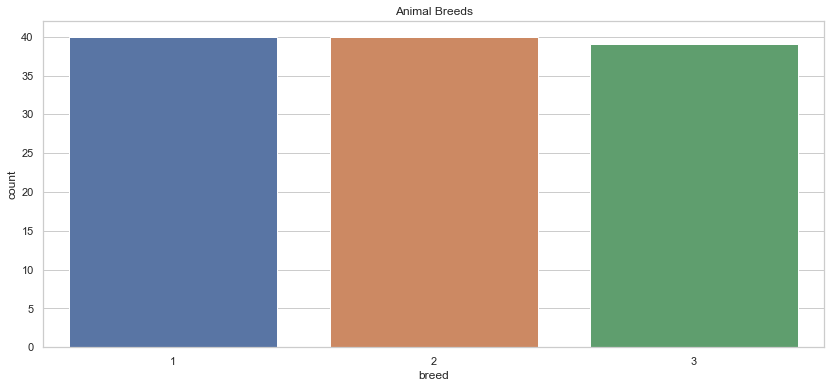

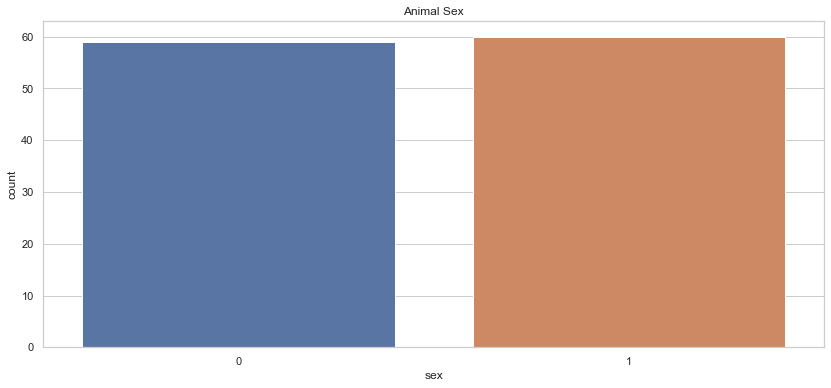

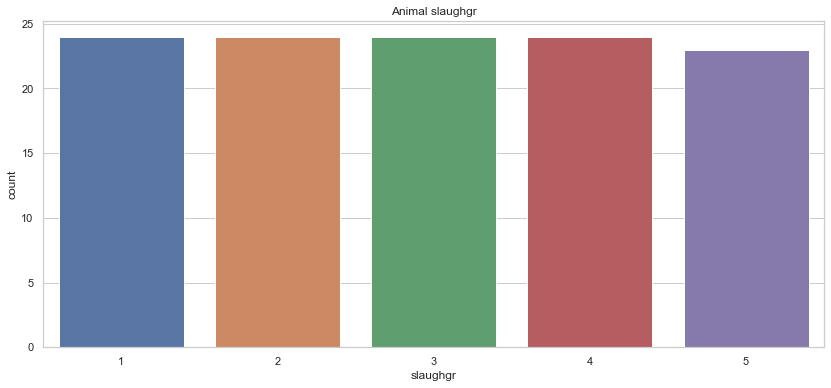

In [4]:
plt.figure(figsize=(14,6))
plt.title('Animal Breeds')
sns.countplot(x='breed', data=data)

plt.figure(figsize=(14,6))
plt.title('Animal Sex')
sns.countplot(x='sex', data=data)

plt.figure(figsize=(14,6))
plt.title('Animal slaughgr')
sns.countplot(x='slaughgr', data=data)

Όπως βλέπουμε παραπάνω, και για τα τρία κατηγορικά χαρακτηριστικά τα δεδομένα είνια κατανεμημένα ομοιόμορφα πράγμα που
σημαίνει ότι δεν υπάρχει μεροληψία ως προς κάποιο συγκεκριμένο χαρακτηριστικό.

## Examine Parts Variance
Θα χρησιοποιήσουμε boxplots για να διαπιστώσουμε τη διακύμανση που παρατηρείται στα βάρη
κάθε τμήματος του ζώου.

<AxesSubplot:>

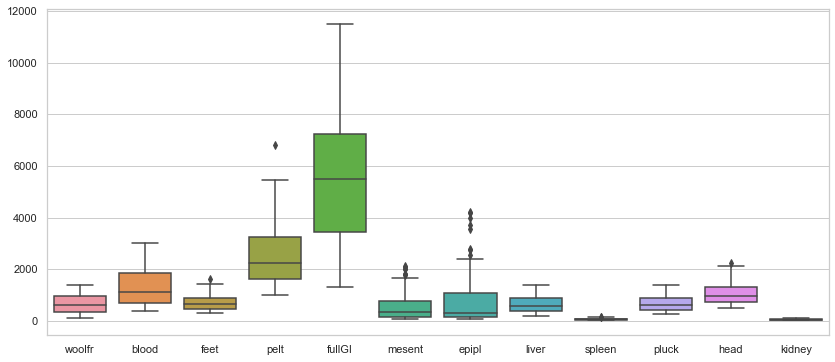

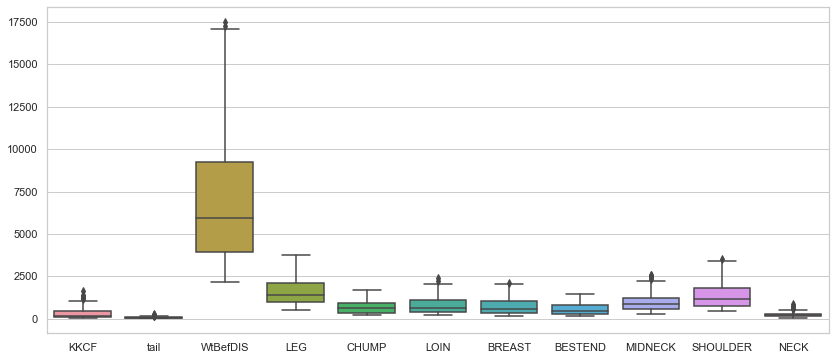

In [5]:
plt.figure(figsize=(14,6))
parts = data[['woolfr','blood','feet','pelt','fullGI','mesent','epipl',
              'liver','spleen', 'pluck', 'head','kidney']]
sns.boxplot(data=parts)

plt.figure(figsize=(14,6))
parts = data[['KKCF', 'tail', 'WtBefDIS', 'LEG', 'CHUMP', 'LOIN',
              'BREAST', 'BESTEND', 'MIDNECK', 'SHOULDER', 'NECK']]
sns.boxplot(data=parts)

Απο τα baxplots παρατηρούμε ότι δεν παρατηρείται ιδιαίτερα μεγάλη διακύμανση στο βάρος των περισσότερων τμημάτων ζώων.
Τη μεγαλύτερη διακύμανση τη παρουσιάζουν τα ακόλουθα χαρακτηριστικά:"blood", "pelt", "fullGI" (?) και "WtfBefDIS" (?).
Επίσης, στο χαρακτηριστικό "epipl" κάποιες τιμές ξεφεύγουν και ίσως είναι outliers.

## Feature Correlation
Αρχικά θα διερευνήσουμε το βαθμό συσχέτισης μεταξύ όλων των χαρακτηριστικών.

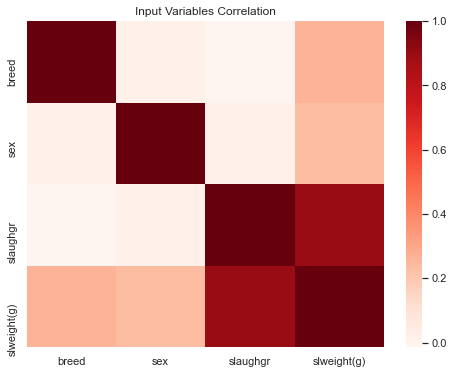

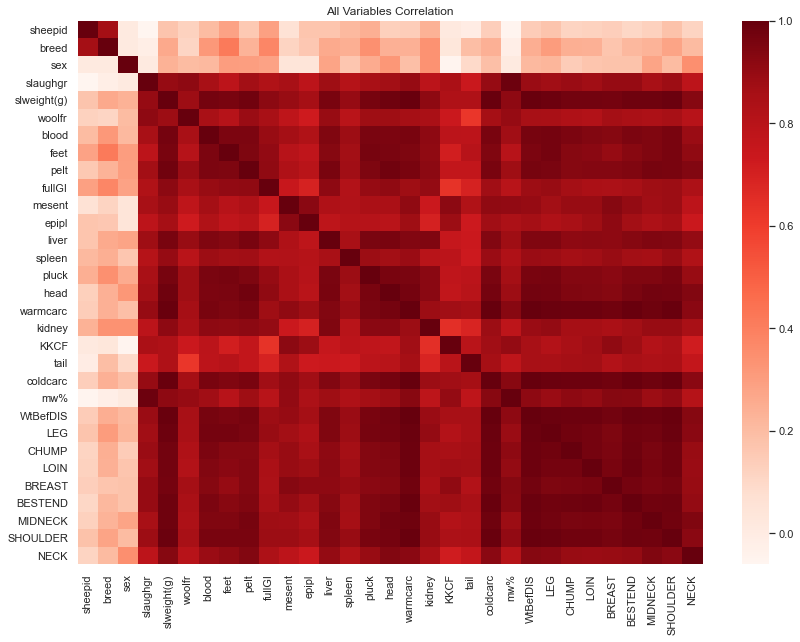

In [6]:
plt.figure(figsize=(8,6))
plt.title('Input Variables Correlation')
input_cols_corr = X.corr()
sns.heatmap(input_cols_corr, annot=False, cmap='Reds')
plt.show()

plt.figure(figsize=(14,10))
plt.title('All Variables Correlation')
output_cols_corr = data.corr()
sns.heatmap(output_cols_corr, annot=False, cmap='Reds')# sns.set(font_scale=0.5)
plt.show()


Παρά το γεγονός ότι τα δεδομένα είναι πάρα πολλά για να είμαστε σε θέση να κατανοήσουμε το heatmap λεπτομερώς μπορούμε
εξάγουμε μεροικά συμπεράσματα απο τη γενική εικόνα τους.

Πιό συγκεκριμένα, στο 1ο heatmap βλέπουμε μια αναπαράσταση του βαθμού συσχέτισης μεταξύ των μεταβλητλών εισόδου. Απο την
αναπαράσταση αυτή είναι εμφανές ότι τα χαρακτηριστιά εισόδου είναι αρκετά ασυσχέτιστα μεταξύ τους με εξάιρεση
τα χαρ/κα "slweight(g)" και "slaughgr" τα οπόια παρουσιάζουν υψηλή συσχέτιση. Αυτό σημαίνει ότι τα χρακτητιστικά εισόδου
είναι αρκετά ανεξάρτητα ώστε η χρήση τους να προσφέρει αρκετή πληροφορία.

Στό 2ο  heatmap είναι εμφανές πως τα δεδομένα εξόδου έχουν υψηλή συσχέτιση μεταξύ τους αλλά καί με τα δεδομένα εισόδου καθώς
το μεγαλύτερο μέςρος του heatmap είναι βαθιά κοκκινισμένο. Επίσης επαληθέυεται αυτό που παρατηρήσαμε στο 1ο heatmap, δηλαδή
ότι οι συσχετίσεις μεταξύ των μεταβλητών εισόδου είναι χαμηλές σε σχέση με τις συσχετίσεις μεταξύ των δεδομένων εξόδου.

## Feature Importance

In [7]:
# Split train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)

# Setup xgb regressor and meta-regressor for multi-output
xgb_reg = xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=90, n_jobs=-1)
mo_meta_reg = MultiOutputRegressor(xgb_reg)
# Fit & predict
mo_meta_reg.fit(X_train, y_train)
y_pred = mo_meta_reg.predict(X_test)
# Evaluate Test
scores_rmse = mean_squared_error(y_test, y_pred, multioutput='raw_values', squared=False)
scores_r2 = r2_score(y_test, y_pred, multioutput='raw_values')
score_avg_rmse = mean_squared_error(y_test, y_pred, multioutput='uniform_average', squared=False)
score_avg_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
# Evaluate Train
y_train_pred = mo_meta_reg.predict(X_train)
train_score_rmse = mean_squared_error(y_train, y_train_pred, multioutput='uniform_average', squared=False)
train_score_r2 = r2_score(y_train, y_train_pred, multioutput='uniform_average')

print("XGBoost")
print("RMSE Raw:\n", scores_rmse)
print("R2 Raw:\n", scores_r2)
print("RMSE Average:\n", score_avg_rmse)
print("R2 Average:\n", score_avg_r2)
# print("RMSE (train): ", train_score_rmse)
# print("R2 (train): ", train_score_r2)

XGBoost
RMSE Raw:
 [ 130.20179264  188.24883469   47.53204012  223.84238534  816.1248879
  132.10043583  174.73757796   94.09099847   15.18538602   47.95538541
   66.86227482 1089.25757162    8.33109858  143.99857809   26.48545867
 1100.26155859    1.67641348  508.88305521  115.28751153   72.21061178
   91.93331223  103.8803427    60.7058962    83.91183826   93.48072656
   32.75192042]
R2 Raw:
 [0.84488427 0.87098782 0.9519994  0.94308918 0.86058475 0.92483373
 0.92092805 0.86300705 0.66652456 0.95356998 0.95429344 0.9670308
 0.69163775 0.82111175 0.69556318 0.96492734 0.99507674 0.9647744
 0.95525843 0.93811554 0.93650775 0.92589358 0.92936467 0.94536991
 0.96681698 0.87492825]
RMSE Average:
 210.38222665792196
R2 Average:
 0.89719535752799


<AxesSubplot:title={'center':'Raw RMSE scores'}>

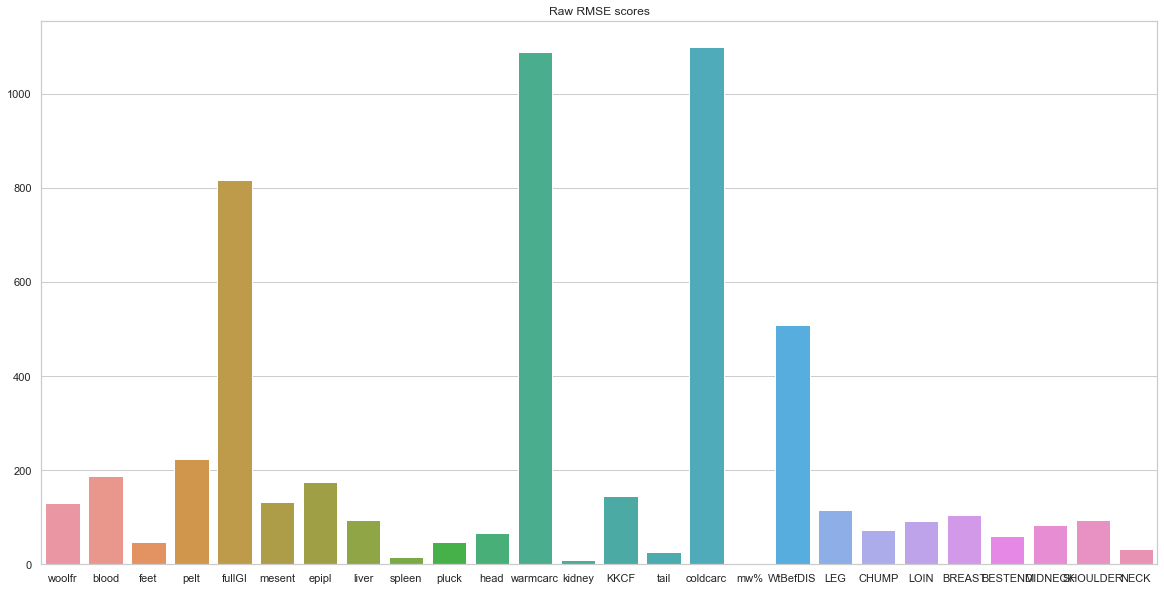

In [8]:
scores_df = pd.DataFrame(columns=y.columns, data=[scores_rmse])

plt.figure(figsize=(20,10))
plt.title('Raw RMSE scores')
sns.barplot(data=scores_df)

Οι μεταβλητές "fullGI", "warmcarc", "coldcarc", "WtBefDIS" έχουν αρκετά μεγάλο σφάλμα (rmse) κατά την πρόβλεψη σε σχέση
με τις υπόλοιπες. Το μέσο ομοιόμορφο σφάλμα είναι 210.38.


<ipython-input-9-11912193ded8>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


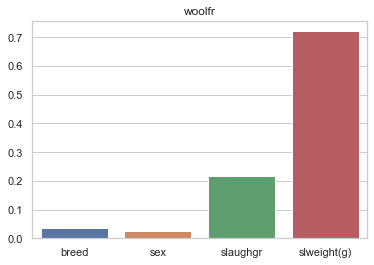

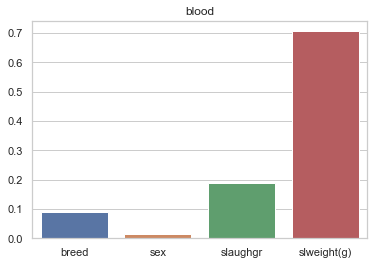

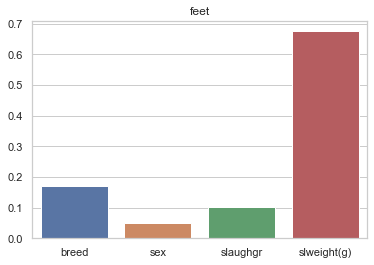

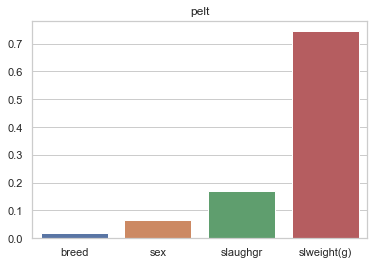

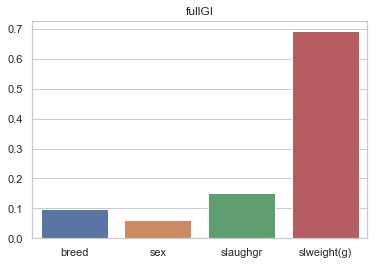

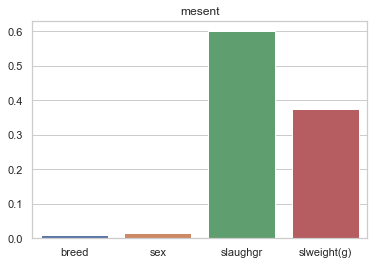

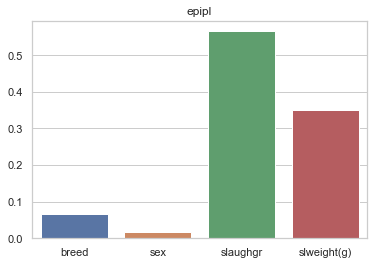

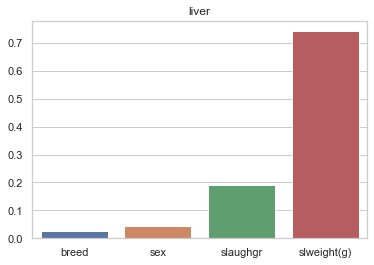

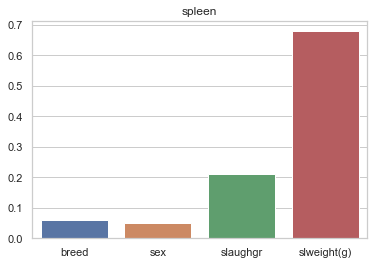

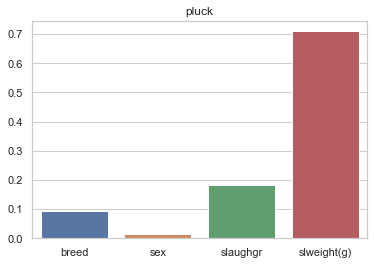

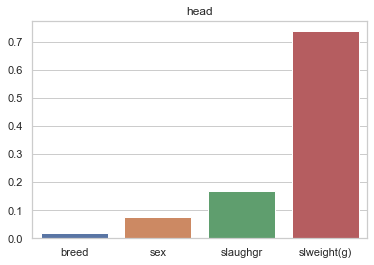

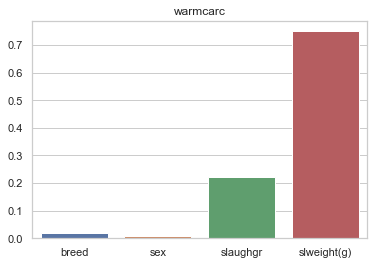

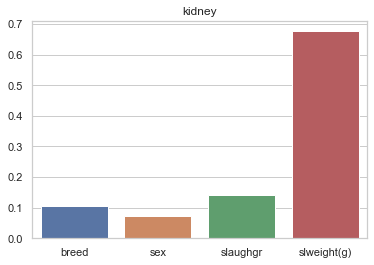

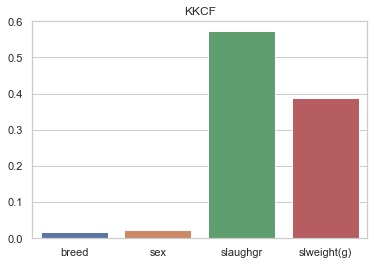

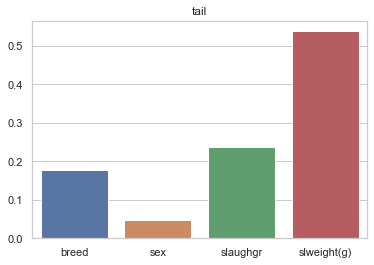

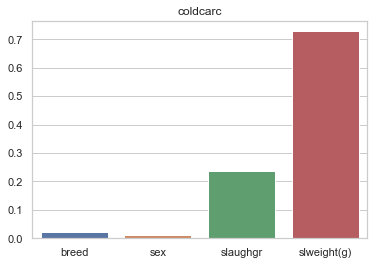

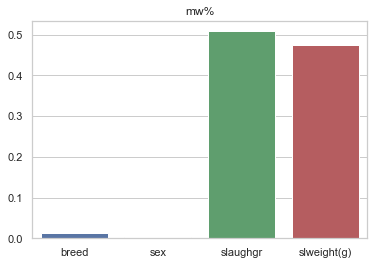

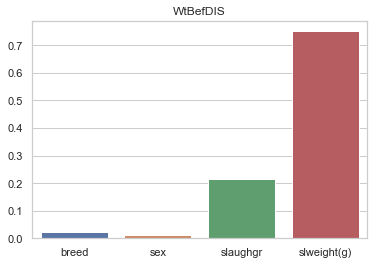

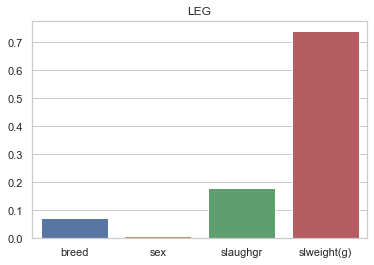

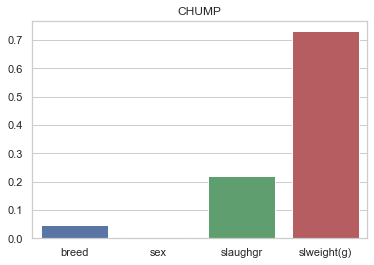

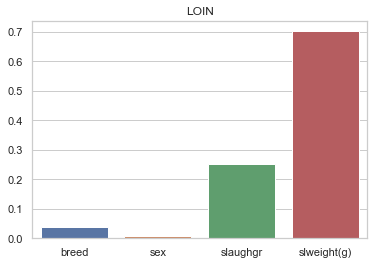

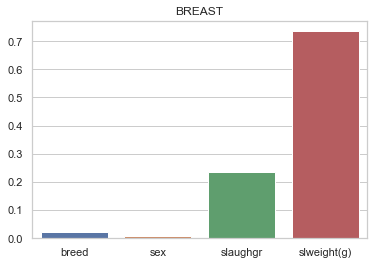

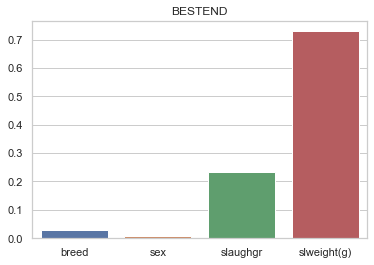

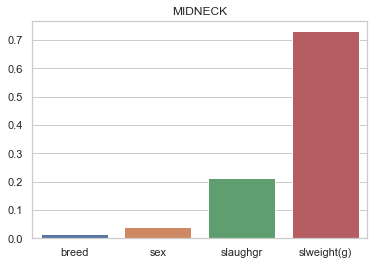

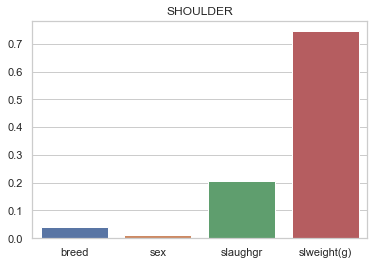

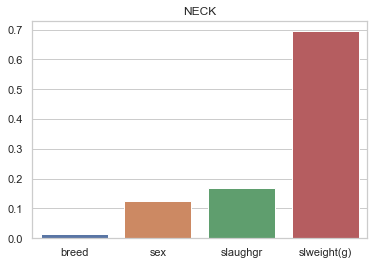

In [9]:
# Get feature importances
count = 0
for est in mo_meta_reg.estimators_:
    df = pd.DataFrame(data=[est.feature_importances_],columns=X.columns)

    plt.figure(figsize=(6,4))
    plt.title(y.columns[count])
    sns.barplot(data=df)
    count+=1

Είναι ξεκάθαρο ότι το πιό σημαντικό χαρακτηριστικό είναι το slwight(g), ενώ το breed και το sex επηρεάζουν πολύ λίγο
τη πρόβλεψη των μεταβλητών στόχων. Το slaughgr επίσης επηρεάζει αρκετά τις περισσότερες μεταβλητές στόχους.


